# 02450 Project 2


The primary goal of Project 2 is to apply supervised learning techniques (regression and classification) to predict properties or classifications of wood based on the cleaned and scaled dataset from Project 1.

In [56]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
import xlrd
import scipy
from scipy.linalg import svd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

### Cleaned and Scaled Data from Project 1

In [98]:
data = pd.read_csv('C:/Users/ongji/OneDrive/Documents/DTU/02450 Introduction to Machine Learning and Data Mining/02450-Project-1/usa_wood_data_formatted.csv')
# print(data.head())  

# Clean data by removing columns with a significant amount of missing values
removed_columns = ['side_hardness','tension_perpendicular_to_grain','impact_bending']
data_cleaned = data.drop(columns=removed_columns)
data_cleaned = data_cleaned.dropna()
# print(data_cleaned.isnull().sum()) # 0 means data is clean


# Extract attribute names (1st row, column 0 to 13)
attributeNames = data_cleaned.columns[:13]
for i in range(len(attributeNames)):
    print(i, attributeNames[i])

# Extract class names to python list, then encode with integers (dict)
classLabels = data_cleaned['classification'].values
classNames = sorted(set(classLabels))
classDict = {className: index for index, className in enumerate(classNames)}
y = np.array([classDict[label] for label in classLabels])


# Preallocate memory, then extract excel data to matrix X
X = data_cleaned.iloc[:,0:13].values

# Compute values of N, M and C.
N = len(y)
M = len(attributeNames)
C = len(classNames)


# Filter out numerical values
X_num = data_cleaned.iloc[:,6:].values



# Scale and substract mean from data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
Y = X_scaled - np.ones((N, 1)) * X_scaled.mean(axis=0)

# PCA by computing SVD of Y
U, S, Vh = svd(Y, full_matrices=False)

# Compute variance explained by principal components
rho = (S * S) / (S * S).sum()

# print("Singular values:", S)
# print("Variance explained:", rho)
# print("Cumulative variance explained:", np.cumsum(rho))

# Convert arrays to PyTorch tensors
X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.FloatTensor(y).unsqueeze(1)


0 common_species_name
1 genus
2 species
3 scientific_name
4 classification
5 moisture_content
6 specific_gravity
7 modulus_of_rupture
8 modulus_of_elasticity
9 work_to_maximum_load
10 compression_parallel_to_grain
11 compression_perpendicular_to_grain
12 shear_parallel_to_grain


###  Two-Level Cross-Validation Model

K1 = outer loop

K2 = inner loop

h = no. of hidden neurons



In [ ]:
# # ANN Model

# # Define variables
# K1 = 10
# K2 = 10

# class ANN(nn.Module):
#     def __init__(self, input_dim):
#         super(ANN, self).__init__()
#         self.layer1 = nn.Linear(input_dim, 128)
#         self.layer2 = nn.Linear(128, 256)
#         self.dropout = nn.Dropout(0.3)
#         self.layer3 = nn.Linear(256, 128)
#         self.layer4 = nn.Linear(128, 64)
#         self.output_layer = nn.Linear(64, 1)

#     def forward(self, x):
#         x = F.relu(self.layer1(x))
#         x = F.relu(self.layer2(x))
#         x = self.dropout(x)
#         x = F.relu(self.layer3(x))
#         x = F.relu(self.layer4(x))
#         x = self.output_layer(x)
#         return x
    

# # Cross-validation
# outer_cv = KFold(n_splits=K1, shuffle=True, random_state=42)
# inner_cv = KFold(n_splits=K2, shuffle=True, random_state=42)

# test_results =[]

# # Outer Loop
# for train_idx, test_idx in outer_cv.split(X_tensor):
#     X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
#     y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]

#     best_model = None
#     lowest_loss = float('inf')

#     # Inner Loop
#     for train_idx_in, val_idx in inner_cv.split(X_train):
#         X_train_inner, X_val = X_train[train_idx_in], X_train[val_idx]
#         y_train_inner, y_val = y_train[train_idx_in], y_train[val_idx]

#         # Define the model and optimizer
#         model = ANN(X_train_inner.shape[1])
#         optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # L2 regularization
#         criterion = nn.MSELoss()
#         #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
#         scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10)


#         # Training phase
#         for epoch in range(100):
#             model.train()
#             optimizer.zero_grad()
#             outputs = model(X_train_inner)
#             loss = criterion(outputs, y_train_inner)
#             loss.backward()
#             optimizer.step()
#             scheduler.step(val_loss)

#             # Validation
#             model.eval()
#             with torch.no_grad():
#                 val_outputs = model(X_val)
#                 val_loss = criterion(val_outputs, y_val)

#             if val_loss < lowest_loss:
#                 best_model = model
#                 lowest_loss = val_loss

#     # Evaluation phase
#     best_model.eval()
#     with torch.no_grad():
#         test_outputs = best_model(X_test)
#         test_loss = criterion(test_outputs, y_test)
#         test_results.append(test_loss.item())

   
# for idx, error, in enumerate(test_results):
#     print(f"Fold {idx+1} MSE: {error}")


In [106]:
# ANN Model

# Define variables
K1 = 10
K2 = 10

class ANN(nn.Module):
    def __init__(self, input_dim, h):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(input_dim, h)
        self.layer2 = nn.Linear(h,h)
        self.output_layer = nn.Linear(h, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output_layer(x)
        return x
    

# Cross-validation
outer_cv = KFold(n_splits=K1, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=K2, shuffle=True, random_state=42)

test_results =[]
inner_errors = []

# Outer Loop
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_tensor)):
    X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
    y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]

    best_h = None
    #best_lambda = None
    best_model = None
    lowest_error = float('inf')

    # Inner Loop
    for h in range(1,20): # onyl try up to 20 hidden neurons
        inner_errors_for_fold = []

        for train_idx_in, val_idx in inner_cv.split(X_train):
            X_train_inner, X_val = X_train[train_idx_in], X_train[val_idx]
            y_train_inner, y_val = y_train[train_idx_in], y_train[val_idx]

            # Define model based on h  
            model = ANN(X_train_inner.shape[1], h)
            optimizer = optim.Adam(model.parameters(), lr=0.01)
            criterion = nn.MSELoss()

            # Training phase
            for epoch in range(100):
                model.train()
                optimizer.zero_grad()
                outputs = model(X_train_inner)
                loss = criterion(outputs, y_train_inner)
                loss.backward()
                optimizer.step()
            

            # Evaluation phase
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val)
                #val_loss = criterion(val_outputs, y_val)
                val_error = mean_squared_error(y_val.numpy(), val_outputs.numpy())
                inner_errors_for_fold.append(val_error)
            
        
        # Find best h for this fold
        avg_inner_error = np.mean(inner_errors_for_fold)
        if avg_inner_error < lowest_error: 
            lowest_error = avg_inner_error
            best_h = h
            
                

    # Evaluate the best model based on best h
    best_model = ANN(X_train.shape[1], best_h)
    optimizer = optim.Adam(best_model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    for epoch in range(50):
        best_model.train()
        optimizer.zero_grad()
        outputs = best_model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    best_model.eval()
    with torch.no_grad():
        test_outputs = best_model(X_test)
        test_error = mean_squared_error(y_test.numpy(), test_outputs.numpy())

    test_results.append((i+1, best_h, test_error))

Fold | h* | Test Error
1 | 15 | 0.11867354065179825
2 | 15 | 0.12076347321271896
3 | 19 | 0.07582762092351913
4 | 18 | 0.12573620676994324
5 | 18 | 0.12871964275836945
6 | 10 | 0.14882414042949677
7 | 18 | 0.09173362702131271
8 | 17 | 0.12654368579387665
9 | 13 | 0.13156214356422424
10 | 15 | 0.17051911354064941


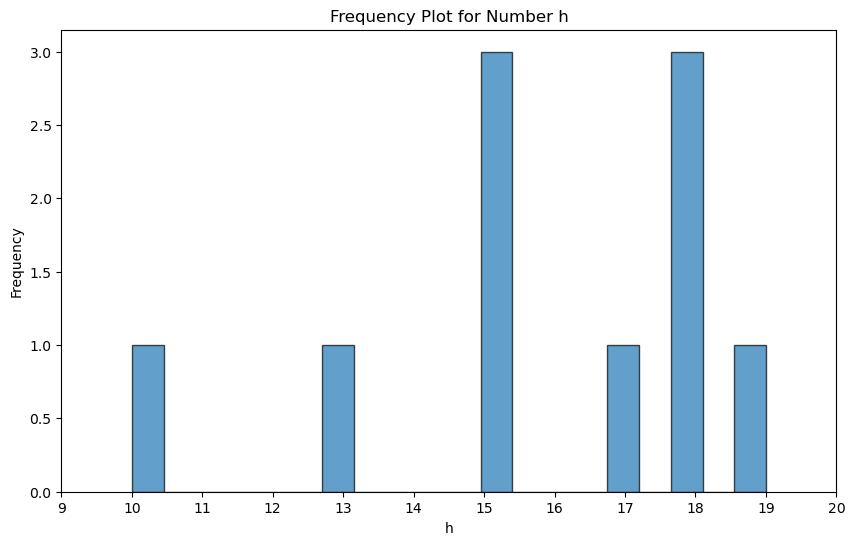

In [121]:
print("Fold | h* | Test Error")
for r in test_results:
    print(f"{r[0]} | {r[1]} | {r[2]}")

h = [r[1] for r in test_results]

# Plot the histogram for the frequency plot of h
plt.figure(figsize=(10, 6))
plt.hist(h, bins=20, edgecolor='black', alpha=0.7)
plt.xticks(range(int(min(h))-1, int(max(h))+2, 1))
plt.xlabel('h')
plt.ylabel('Frequency')
plt.title('Frequency Plot for Number h')
plt.show()

### Feature Selection

Use the features identified as significant from the PCA analysis. 

This includes 'modulus of rupture', 'shear parallel to grain', 'compression parallel to grain', 'modulus of elasticity', 'work to maximum load', and 'specific gravity'. 

These are strong candidates for your predictive models.

### Regression 

To predict a continuous variable based on other variables. 

To predict the values/property of one feature based on other features.